In [1]:
#Load packages

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from src.battery_model import BatteryModel
from src.data_processing import process_data
from run import run_simulation

%load_ext autoreload
%autoreload 2

# Interactive simulation

In [2]:
# Load data from data folder

battery_spec_file = os.path.join('data', 'battery_specs.csv')
half_hourly_price_file = os.path.join('data', 'half_hourly_data.csv')
daily_price_file = os.path.join('data', 'daily_data.csv')

battery_specs_dict, all_data = process_data(battery_spec_file, half_hourly_price_file, daily_price_file)

In [3]:
# test on small subset of data
small_data = all_data.iloc[0:480]

In [4]:
output = run_simulation(battery_specs_dict, 
                        small_data, 
                        planning_horizon=144,
                        execution_horizon=48,  
                        delta_t=0.5,
                        trading_freq=[1, 1, 48], 
                        S_init=0,
                        consider_depreciation=True)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\zhout\Documents\Resume\Aurora_interview\battery_optimization\run.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat((output, plan), ignore_index=True)
100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


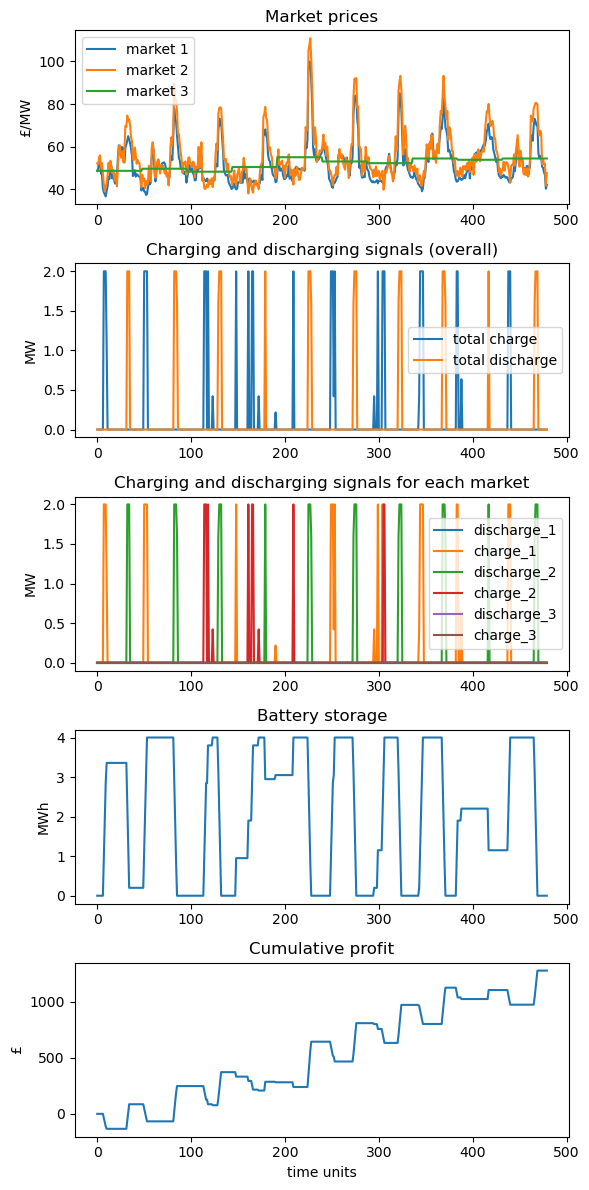

In [5]:
# visualize simulation results

BatteryModel.plot_output(small_data, output[:])

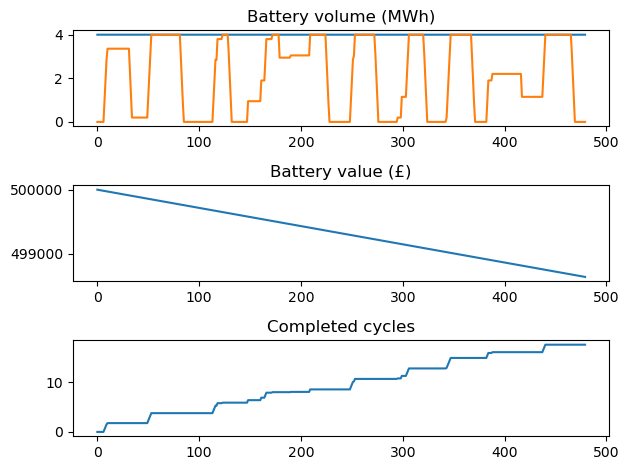

In [6]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(output['Battery volume (MWh)'])
axs[0].plot(output['Storage value (MWh)'])
axs[1].plot(output['Battery value (£)'])
axs[2].plot(output['Completed cycles'])

axs[0].set_title('Battery volume (MWh)')
axs[1].set_title('Battery value (£)')
axs[2].set_title('Completed cycles')

plt.tight_layout()

# Validation of simulation outputs

In [7]:
# read full output data

full_output = pd.read_csv(os.path.join('output', 'output.csv'))
full_output.head()

,Unnamed: 0,Datetime,Charge (MW) from market 1,Discharge (MW) from market 1,Charge (MW) from market 2,Discharge (MW) from market 2,Charge (MW) from market 3,Discharge (MW) from market 3,Total charge (MW),Total discharge (MW),Storage value (MWh),Profits (£),Battery volume (MWh),Battery value (£),Completed cycles
0,0,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,500000.000000,0.0
1,1,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,499997.148072,0.0
2,2,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,499994.296144,0.0
3,3,2018-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,499991.444216,0.0
4,4,2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,499988.592288,0.0


(3.9, 4.0)

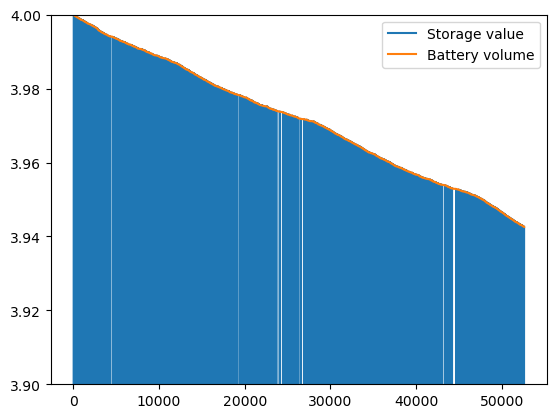

In [9]:
# visualize battery volume over time and storage value 
# storage value is constrained by battery volume as the upper bound

plt.plot(np.arange(len(full_output)), full_output['Storage value (MWh)'], label='Storage value')
plt.plot(np.arange(len(full_output)), full_output['Battery volume (MWh)'], label='Battery volume')
plt.legend()
plt.ylim(3.9, 4)

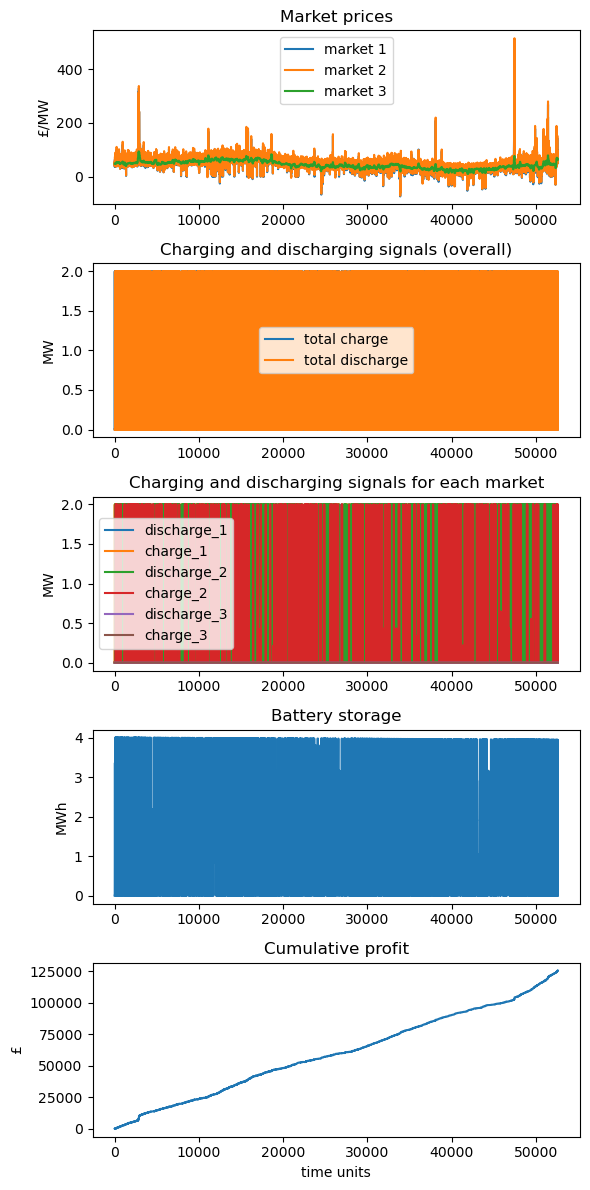

In [10]:
BatteryModel.plot_output(all_data, full_output)

# Error of approximation for V_t

As we can see, the error of approximation of V_t using a linear function in terms of cumulative charge is very small for a low f of 1e-5

linearized gradient: -9.900037123649063e-06, battery deterioration (f):1e-05
sum of squared error of approximation over 100 MWh of charge: 4.61718098884068e-16


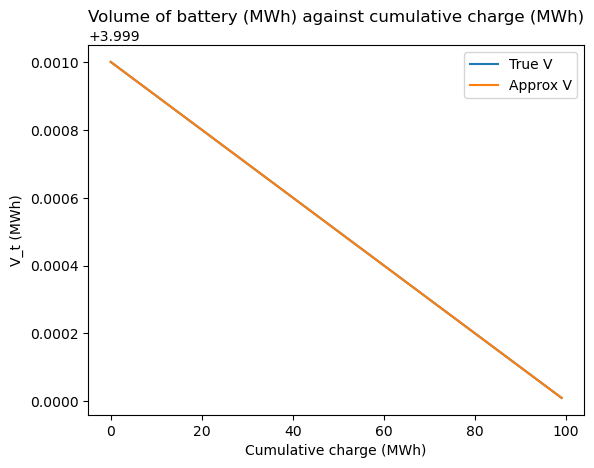

In [11]:
# plots the volume of battery (MWh) against cumulative charge (MWh)

f = 1e-5 # battery deteroriation per cycle of charge
V_0 = 4 # initial battery volume

# iterate in increasing cumulative charge 0 - 99
true_V = [V_0]
for i in range(1,100):

    # cycle completed with 1 MWh of charge = 1MWh/V_{t-1}
    cycle_per_charge = 1/true_V[-1]

    # new battery volume V_t = V_{t-1} * (1-f)^cycle
    true_V.append(true_V[-1] * (1-f)**cycle_per_charge)

# compute linearized gradient
gradient = (true_V[-1] - true_V[0])/len(true_V)
print(f"linearized gradient: {gradient}, battery deterioration (f):{f}")

# approximate true_V using linear function of cumulative charge
approx_V = [V_0 - f * c for c in range(100)]

print(f"sum of squared error of approximation over 100 MWh of charge: {np.sum((np.array(true_V) - np.array(approx_V))**2)}")

plt.title("Volume of battery (MWh) against cumulative charge (MWh)")
plt.plot(true_V, label='True V')
plt.plot(approx_V, label='Approx V')
plt.ylabel('V_t (MWh)')
plt.xlabel('Cumulative charge (MWh)')
plt.legend()